In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

In [3]:
import s3fs
import hvac
import os

client = hvac.Client(url='https://vault.lab.sspcloud.fr',
                     token=os.environ['VAULT_TOKEN'])

secret = os.environ['VAULT_MOUNT'] + os.environ['VAULT_TOP_DIR'] + '/s3'
mount_point, secret_path = secret.split('/', 1)
secret_dict = client.secrets.kv.read_secret_version(path=secret_path, mount_point = mount_point)

os.environ["AWS_ACCESS_KEY_ID"] = secret_dict['data']['data']['ACCESS_KEY_ID']
os.environ["AWS_SECRET_ACCESS_KEY"] = secret_dict['data']['data']['SECRET_ACCESS_KEY']
try:
    del os.environ['AWS_SESSION_TOKEN']
except KeyError:
    pass

In [4]:
fs = s3fs.S3FileSystem(
    client_kwargs={'endpoint_url': 'https://'+'minio.lab.sspcloud.fr'},
    key=os.environ["AWS_ACCESS_KEY_ID"],
    secret=os.environ["AWS_SECRET_ACCESS_KEY"]
)
fs.ls('projet-slums-detection/Donnees/BDTOPO/')

['projet-slums-detection/Donnees/BDTOPO/BDTOPO_2-1_TOUSTHEMES_SHP_RGM04UTM38S_D976_2016-04-01',
 'projet-slums-detection/Donnees/BDTOPO/BDTOPO_2-1_TOUSTHEMES_SHP_RGM04UTM38S_D976_2016-04-01.7z',
 'projet-slums-detection/Donnees/BDTOPO/BDTOPO_2-1_TOUSTHEMES_SHP_RGR92UTM40S_D974_2016-04-01',
 'projet-slums-detection/Donnees/BDTOPO/BDTOPO_2-1_TOUSTHEMES_SHP_RGR92UTM40S_D974_2016-04-01.7z',
 'projet-slums-detection/Donnees/BDTOPO/BDTOPO_2-1_TOUSTHEMES_SHP_UTM20W84GUAD_D971_2016-04-01',
 'projet-slums-detection/Donnees/BDTOPO/BDTOPO_2-1_TOUSTHEMES_SHP_UTM20W84GUAD_D971_2016-04-01.7z',
 'projet-slums-detection/Donnees/BDTOPO/BDTOPO_2-1_TOUSTHEMES_SHP_UTM20W84MART_D972_2016-04-01',
 'projet-slums-detection/Donnees/BDTOPO/BDTOPO_2-1_TOUSTHEMES_SHP_UTM20W84MART_D972_2016-04-01.7z',
 'projet-slums-detection/Donnees/BDTOPO/BDTOPO_2-1_TOUSTHEMES_SHP_UTM22RGFG95_D973_2016-04-01',
 'projet-slums-detection/Donnees/BDTOPO/BDTOPO_2-1_TOUSTHEMES_SHP_UTM22RGFG95_D973_2016-04-01.7z',
 'projet-slums-detect

## Analyse évolution des BDTOPO en Guyane

In [44]:
old_types = ["BATI_REMARQUABLE", "BATI_INDUSTRIEL", "CONSTRUCTION_LEGERE"]
old_types_col_mapping = {
    "BATI_REMARQUABLE": "Remarquable",
    "BATI_INDUSTRIEL": "Industriel",
    "CONSTRUCTION_LEGERE": "Construction légère" 
}

In [45]:
import sys
sys.path.append("../src/")
from utils import load_bdtopo
import shutil

environment = get_environment()

batiment_dict = {}
for year, dep_dict in environment["sources"]["BDTOPO"].items():
    dep_path = os.path.join("projet-slums-detection", dep_dict["guyane"])
    folder_name = os.path.basename(dep_path)
    fs.get(dep_path, folder_name, recursive=True)
    
    for root, dirs, files in os.walk(folder_name):
        if "BATIMENT.shp" in files:
            file_path = os.path.join(root, "BATIMENT.shp")
            df = gpd.read_file(file_path)
        elif "BATI_INDIFFERENCIE.SHP" in files:
            file_path = os.path.join(root, "BATI_INDIFFERENCIE.SHP")
            df = gpd.read_file(file_path)
            df["NATURE"] = "Indifférenciée"
            for type_bat in ["BATI_REMARQUABLE", "BATI_INDUSTRIEL", "CONSTRUCTION_LEGERE"]:
                try:
                    file_path = os.path.join(root, type_bat + ".SHP")
                    new_df = gpd.read_file(file_path)
                    new_df["NATURE"] = old_types_col_mapping[type_bat]
                    df = pd.concat([df, new_df])
                except:
                    pass
    if not file_path:
        raise ValueError("No valid shapefile file found.")
    batiment_dict[year] = df
    
    shutil.rmtree(folder_name)

In [46]:
df = batiment_dict[2022]
df.head()

,ID,NATURE,USAGE1,USAGE2,LEGER,ETAT,DATE_CREAT,DATE_MAJ,DATE_APP,DATE_CONF,...,MAT_MURS,MAT_TOITS,HAUTEUR,Z_MIN_SOL,Z_MIN_TOIT,Z_MAX_TOIT,Z_MAX_SOL,ORIGIN_BAT,APP_FF,geometry
0,BATIMENT0000002200075739,Indifférenciée,Indifférencié,NaN,Non,En service,2018-12-11 17:53:51,2019-03-15 18:34:53,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Autre,NaN,"POLYGON Z ((356654.100 545172.100 -1000.000, 3..."
1,BATIMENT0000002200087667,Indifférenciée,Indifférencié,NaN,Non,En service,2018-12-12 17:21:53,2019-03-15 18:34:53,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Imagerie aérienne,NaN,"POLYGON Z ((355460.300 545993.000 -1000.000, 3..."
2,BATIMENT0000002200158349,Indifférenciée,Indifférencié,NaN,Non,En service,2018-12-14 16:10:20,2019-03-15 18:34:53,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Imagerie aérienne,NaN,"POLYGON Z ((354335.600 545373.700 -1000.000, 3..."
3,BATIMENT0000002200075740,Indifférenciée,Indifférencié,NaN,Non,En service,2018-12-11 17:53:51,2019-03-15 18:34:53,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Autre,NaN,"POLYGON Z ((356669.300 545116.600 -1000.000, 3..."
4,BATIMENT0000002200158350,Indifférenciée,Indifférencié,NaN,Non,En service,2018-12-14 16:10:20,2019-03-15 18:34:53,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Imagerie aérienne,NaN,"POLYGON Z ((354344.800 545397.600 -1000.000, 3..."


### Evolution du nombre de bâtiments

In [47]:
nrows = [df.shape[0] for year, df in batiment_dict.items()]

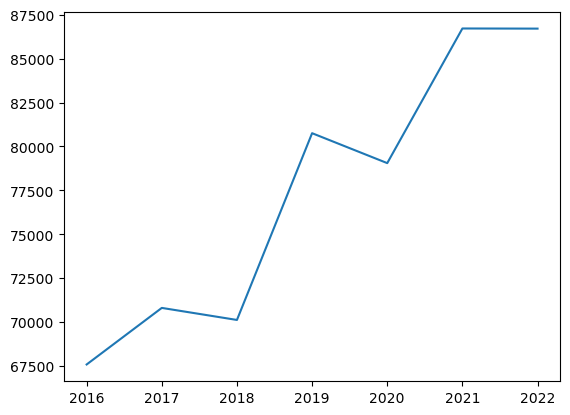

In [48]:
from matplotlib import pyplot as plt

plt.plot(batiment_dict.keys(), nrows)
plt.show()

In [49]:
df = batiment_dict[2022]
df.NATURE.value_counts()

Indifférenciée                        83578
Industriel, agricole ou commercial     2588
Serre                                   455
Eglise                                   48
Tribune                                  19
Chapelle                                  9
Tour, donjon                              5
Silo                                      2
Fort, blockhaus, casemate                 2
Moulin à vent                             1
Monument                                  1
Name: NATURE, dtype: int64

In [50]:
batiment_dict[2016]

,ID,PREC_PLANI,PREC_ALTI,ORIGIN_BAT,HAUTEUR,Z_MIN,Z_MAX,geometry,NATURE
0,BATIMENT0000000069964056,1.5,1.0,Autre,3,105.3,105.8,"POLYGON Z ((165675.300 404171.600 105.800, 165...",Indifférenciée
1,BATIMENT0000000069962782,1.5,1.0,Autre,5,100.3,100.3,"POLYGON Z ((144896.700 422918.200 100.300, 144...",Indifférenciée
2,BATIMENT0000000069962362,1.5,1.0,Autre,5,11.6,11.6,"POLYGON Z ((411048.700 431085.000 11.600, 4110...",Indifférenciée
3,BATIMENT0000000069961831,1.5,1.0,Autre,7,12.0,12.0,"POLYGON Z ((410908.300 430429.600 12.000, 4109...",Indifférenciée
4,BATIMENT0000000069961632,1.5,1.0,Autre,5,14.1,14.1,"POLYGON Z ((412303.300 430894.500 14.100, 4123...",Indifférenciée
...,...,...,...,...,...,...,...,...,...
2334,BATIMENT0000000071319270,10.0,9999.0,NR,0,9999.0,9999.0,"POLYGON Z ((296522.300 585580.400 9999.000, 29...",Industriel
2335,BATIMENT0000000071319271,10.0,9999.0,NR,0,9999.0,9999.0,"POLYGON Z ((296495.100 585579.600 9999.000, 29...",Industriel
2336,BATIMENT0000000071319272,10.0,9999.0,NR,0,9999.0,9999.0,"POLYGON Z ((296752.400 585546.700 9999.000, 29...",Industriel
2337,BATIMENT0000000071319273,10.0,9999.0,NR,0,9999.0,9999.0,"POLYGON Z ((296753.700 585563.600 9999.000, 29...",Industriel


In [51]:
batiment_dict[2016].NATURE.value_counts()

Indifférenciée    65068
Industriel         2339
Remarquable         179
Name: NATURE, dtype: int64

In [56]:
count_df_list = []
for year, df in batiment_dict.items():
    count_df = df.groupby(["NATURE"])["ID"].count().reset_index()
    count_df["year"] = year
    count_df_list.append(count_df)

count_df = pd.concat(count_df_list)

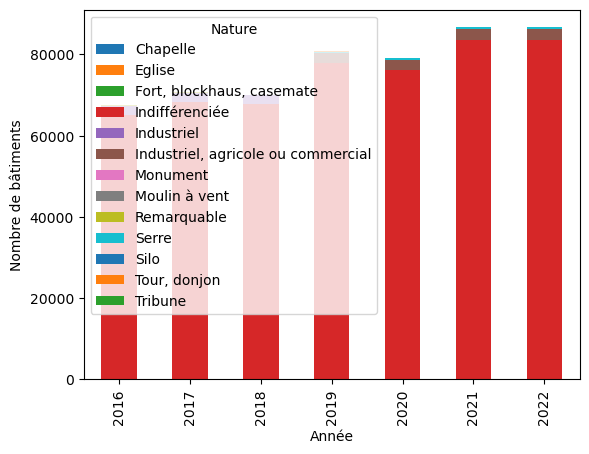

In [61]:
pivot_df = count_df.pivot_table(index='year', columns='NATURE', values='ID', aggfunc='sum')
pivot_df.plot(kind='bar', stacked=True)
plt.xlabel('Année')
plt.ylabel('Nombre de bâtiments')
plt.legend(title='Nature', loc="upper left")
plt.show()

### Nouveaux bâtiments

In [70]:
import numpy as np

years = []
n_app = []
n_disapp = []
for i in np.arange(2016, 2022, 1):
    df_past = batiment_dict[i]
    df = batiment_dict[i+1]
    ids_past = df_past.ID
    ids = df.ID
    n_disapp.append((~ids_past.isin(ids)).sum())
    n_app.append((~ids.isin(ids_past)).sum())
    years.append(i+1)

In [71]:
pd.DataFrame({
    "year": years,
    "n_app": n_app,
    "n_disapp": n_disapp
})

,year,n_app,n_disapp
0,2017,70807,67586
1,2018,816,1502
2,2019,16226,5593
3,2020,237,1941
4,2021,14806,7140
5,2022,369,377


Pourquoi les grosses différences entre 2016 et 2017 ?

In [72]:
batiment_dict[2016].ID

0       BATIMENT0000000069964056
1       BATIMENT0000000069962782
2       BATIMENT0000000069962362
3       BATIMENT0000000069961831
4       BATIMENT0000000069961632
                  ...           
2334    BATIMENT0000000071319270
2335    BATIMENT0000000071319271
2336    BATIMENT0000000071319272
2337    BATIMENT0000000071319273
2338    BATIMENT0000000071319274
Name: ID, Length: 67586, dtype: object

In [73]:
batiment_dict[2017].ID

0       BATIMENT0000001369963756
1       BATIMENT0000001369963754
2       BATIMENT0000001369962269
3       BATIMENT0000001369963719
4       BATIMENT0000001369917541
                  ...           
2259    BATIMENT0000001372937370
2260    BATIMENT0000001372937209
2261    BATIMENT0000001372937247
2262    BATIMENT0000001372936809
2263    BATIMENT0000001372940313
Name: ID, Length: 70807, dtype: object

In [77]:
len(list(batiment_dict[2016].ID)[0])

24

In [78]:
len(list(batiment_dict[2017].ID)[0])

24

In [81]:
id_numbers = []
for identifier in batiment_dict[2016].ID:
    id_number = int(identifier[8:])
    id_numbers.append(id_number)

In [82]:
min(id_numbers)

69914600

In [83]:
max(id_numbers)

72296424

In [87]:
id_numbers_17 = []
for identifier in batiment_dict[2017].ID:
    id_number_17 = int(identifier[8:])
    id_numbers_17.append(id_number_17)

In [88]:
min(id_numbers_17)

1369914600

In [89]:
max(id_numbers_17)

2001954261

Ok on va ignorer 2017.

In [90]:
evol_df = pd.DataFrame({
    "year": years,
    "n_app": n_app,
    "n_disapp": n_disapp
})

In [91]:
evol_df

,year,n_app,n_disapp
0,2017,70807,67586
1,2018,816,1502
2,2019,16226,5593
3,2020,237,1941
4,2021,14806,7140
5,2022,369,377


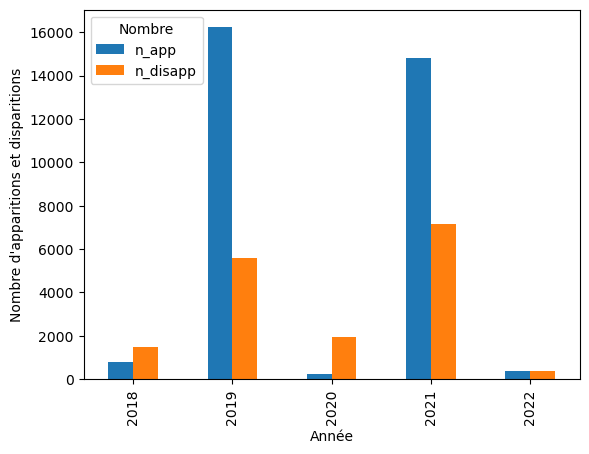

In [94]:
evol_df[evol_df.year != 2017].plot(x='year', kind='bar')
plt.xlabel('Année')
plt.ylabel("Nombre d'apparitions et disparitions")
plt.legend(title='Nombre', loc="upper left")
plt.show()

En 2019 et 2021: pas mal de changements : qu'est-ce qui explique ça ? 

### Aire totale

In [95]:
areas = [df.dissolve().area for year, df in batiment_dict.items()]

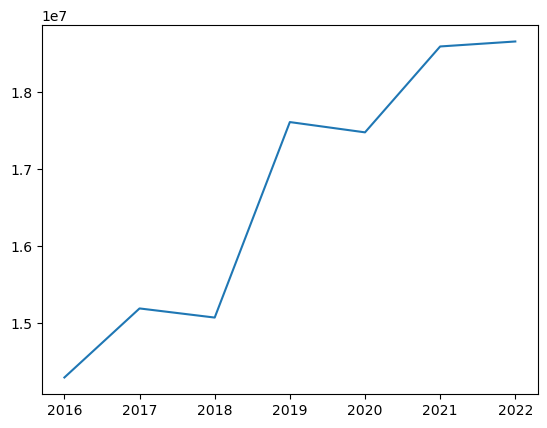

In [96]:
plt.plot(batiment_dict.keys(), areas)
plt.show()

Evolution ressemble à l'évolution du nombre de bâtiments.

### Dates ?

In [99]:
batiment_dict[2022].columns

Index(['ID', 'NATURE', 'USAGE1', 'USAGE2', 'LEGER', 'ETAT', 'DATE_CREAT',
       'DATE_MAJ', 'DATE_APP', 'DATE_CONF', 'SOURCE', 'ID_SOURCE',
       'PREC_PLANI', 'PREC_ALTI', 'NB_LOGTS', 'NB_ETAGES', 'MAT_MURS',
       'MAT_TOITS', 'HAUTEUR', 'Z_MIN_SOL', 'Z_MIN_TOIT', 'Z_MAX_TOIT',
       'Z_MAX_SOL', 'ORIGIN_BAT', 'APP_FF', 'geometry'],
      dtype='object')

In [100]:
batiment_dict[2017].columns

Index(['ID', 'PREC_PLANI', 'PREC_ALTI', 'ORIGIN_BAT', 'HAUTEUR', 'Z_MIN',
       'Z_MAX', 'geometry', 'NATURE'],
      dtype='object')

Dans les vieilles bases on a pas les variables de dates

### Géographiquement, apparitions / disparition par commune ?

In [101]:
dep_to_crs = {
    "971": "4559",
    "973": "2972",
    "972": "4559",
    "976": "4471",
    "974": "2975",
    "977": "4559",
    "978": "4559"
}

In [109]:
import pyreadr
from shapely import wkt

fs.get('projet-slums-detection/Donnees/RIL/rca_geometry_ilots.rds', 'rca_geometry_ilots.rds')
result = pyreadr.read_r('rca_geometry_ilots.rds')
os.remove('rca_geometry_ilots.rds')

In [110]:
df_geom = result[None]
df_geom['wkt'] = df_geom['wkt'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df_geom, geometry="wkt", crs="EPSG:4326")

In [111]:
gdf.head()

,depcom,gr,code_ilot,wkt,srid
0,97422,3,DL06,"MULTIPOLYGON (((55.56003 -21.22883, 55.56142 -...",4326
1,97422,1,CX04,"MULTIPOLYGON (((55.52972 -21.19911, 55.52997 -...",4326
2,97405,2,AB01,"MULTIPOLYGON (((55.59368 -21.29036, 55.59485 -...",4326
3,97405,4,AB02,"MULTIPOLYGON (((55.58636 -21.31395, 55.58649 -...",4326
4,97418,5,AV19,"MULTIPOLYGON (((55.51758 -20.91979, 55.51887 -...",4326


In [112]:
# Filtering departement 
gdf["dep"] = gdf.depcom.str[:3]
gdf = gdf[gdf.dep == "973"]
gdf["wkt"] = [geom.buffer(0) for geom in gdf["wkt"]]

depcom_geometries = gdf.dissolve(by="depcom").to_crs("epsg:" + dep_to_crs["973"])

In [125]:
depcom_geometries.crs

<Derived Projected CRS: EPSG:2972>
Name: RGFG95 / UTM zone 22N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: French Guiana - east of 54°W, onshore and offshore.
- bounds: (-54.0, 2.17, -49.45, 8.88)
Coordinate Operation:
- name: UTM zone 22N
- method: Transverse Mercator
Datum: Reseau Geodesique Francais Guyane 1995
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [115]:
years = []
geometries_app = []
geometries_disapp = []
for i in np.arange(2016, 2022, 1):
    df_past = batiment_dict[i]
    df = batiment_dict[i+1]
    ids_past = df_past.ID
    ids = df.ID
    geometries_disapp.append(df_past[~(df_past.ID.isin(ids))].geometry)
    geometries_app.append(df[~(df.ID.isin(ids_past))].geometry)
    years.append(i+1)

In [132]:
df_past = batiment_dict[2017]
df = batiment_dict[2017]
ids_past = df_past.ID
ids = df.ID
df_past[~(df_past.ID.isin(ids))].crs

<Derived Projected CRS: PROJCS["RGFG95_UTM_Zone_22N",GEOGCS["GCS_RGFG95",D ...>
Name: RGFG95_UTM_Zone_22N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 22N
- method: Transverse Mercator
Datum: Not_specified_based_on_GRS_1980_ellipsoid
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [133]:
df_past.crs

<Derived Projected CRS: PROJCS["RGFG95_UTM_Zone_22N",GEOGCS["GCS_RGFG95",D ...>
Name: RGFG95_UTM_Zone_22N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 22N
- method: Transverse Mercator
Datum: Not_specified_based_on_GRS_1980_ellipsoid
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [134]:
batiment_dict[2017].crs

<Derived Projected CRS: PROJCS["RGFG95_UTM_Zone_22N",GEOGCS["GCS_RGFG95",D ...>
Name: RGFG95_UTM_Zone_22N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 22N
- method: Transverse Mercator
Datum: Not_specified_based_on_GRS_1980_ellipsoid
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [135]:
batiment_dict[2022].crs

<Derived Projected CRS: EPSG:2972>
Name: RGFG95 / UTM zone 22N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: French Guiana - east of 54°W, onshore and offshore.
- bounds: (-54.0, 2.17, -49.45, 8.88)
Coordinate Operation:
- name: UTM zone 22N
- method: Transverse Mercator
Datum: Reseau Geodesique Francais Guyane 1995
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [140]:
batiment_dict[2018]

,ID,PREC_PLANI,PREC_ALTI,ORIGIN_BAT,HAUTEUR,Z_MIN,Z_MAX,geometry,NATURE
0,BATIMENT0000001369963756,1.5,1.0,Autre,5,120.9,121.4,"POLYGON Z ((162638.500 403479.500 121.400, 162...",Indifférenciée
1,BATIMENT0000001369939344,1.5,1.0,Autre,3,7.9,8.3,"POLYGON Z ((358331.500 541513.900 8.300, 35833...",Indifférenciée
2,BATIMENT0000001369939279,1.5,1.0,Autre,3,7.5,7.7,"POLYGON Z ((358350.800 541613.100 7.500, 35835...",Indifférenciée
3,BATIMENT0000001369917950,1.5,1.0,Autre,3,28.6,28.6,"POLYGON Z ((234883.400 610542.000 28.600, 2348...",Indifférenciée
4,BATIMENT0000001369919919,1.5,1.0,Autre,5,7.1,7.1,"POLYGON Z ((164600.300 608740.600 7.100, 16459...",Indifférenciée
...,...,...,...,...,...,...,...,...,...
2165,BATIMENT0000001372937371,10.0,9999.0,NR,0,9999.0,9999.0,"POLYGON Z ((205171.900 590086.900 9999.000, 20...",Industriel
2166,BATIMENT0000001372937226,10.0,9999.0,NR,0,9999.0,9999.0,"POLYGON Z ((171942.700 607235.300 9999.000, 17...",Industriel
2167,BATIMENT0000001372928650,10.0,9999.0,NR,0,9999.0,9999.0,"POLYGON Z ((425502.400 465327.600 9999.000, 42...",Industriel
2168,BATIMENT0000001372940233,10.0,9999.0,NR,0,9999.0,9999.0,"POLYGON Z ((373291.000 475486.400 9999.000, 37...",Industriel


In [139]:
batiment_dict[2018].to_crs("EPSG:2972")

,ID,PREC_PLANI,PREC_ALTI,ORIGIN_BAT,HAUTEUR,Z_MIN,Z_MAX,geometry,NATURE
0,BATIMENT0000001369963756,1.5,1.0,Autre,5,120.9,121.4,"POLYGON Z ((162638.500 403479.500 121.400, 162...",Indifférenciée
1,BATIMENT0000001369939344,1.5,1.0,Autre,3,7.9,8.3,"POLYGON Z ((358331.500 541513.900 8.300, 35833...",Indifférenciée
2,BATIMENT0000001369939279,1.5,1.0,Autre,3,7.5,7.7,"POLYGON Z ((358350.800 541613.100 7.500, 35835...",Indifférenciée
3,BATIMENT0000001369917950,1.5,1.0,Autre,3,28.6,28.6,"POLYGON Z ((234883.400 610542.000 28.600, 2348...",Indifférenciée
4,BATIMENT0000001369919919,1.5,1.0,Autre,5,7.1,7.1,"POLYGON Z ((164600.300 608740.600 7.100, 16459...",Indifférenciée
...,...,...,...,...,...,...,...,...,...
2165,BATIMENT0000001372937371,10.0,9999.0,NR,0,9999.0,9999.0,"POLYGON Z ((205171.900 590086.900 9999.000, 20...",Industriel
2166,BATIMENT0000001372937226,10.0,9999.0,NR,0,9999.0,9999.0,"POLYGON Z ((171942.700 607235.300 9999.000, 17...",Industriel
2167,BATIMENT0000001372928650,10.0,9999.0,NR,0,9999.0,9999.0,"POLYGON Z ((425502.400 465327.600 9999.000, 42...",Industriel
2168,BATIMENT0000001372940233,10.0,9999.0,NR,0,9999.0,9999.0,"POLYGON Z ((373291.000 475486.400 9999.000, 37...",Industriel


In [116]:
geometries_evol_df = pd.DataFrame({
    "year": years,
    "app": geometries_app,
    "disapp": geometries_disapp
})

In [117]:
geometries_evol_df

,year,app,disapp
0,2017,0 POLYGON Z ((162638.500 403479.500 121....,0 POLYGON Z ((165675.300 404171.600 105....
1,2018,1062 POLYGON Z ((352668.400 546012.400 9.3...,55 POLYGON Z ((123664.100 474314.500 56.6...
2,2019,59271 POLYGON Z ((356654.100 545172.100 -10...,99 POLYGON Z ((335418.800 503625.900 10.7...
3,2020,1 POLYGON Z ((164180.500 609352.600 4.0...,18 POLYGON Z ((234883.400 610542.000 28....
4,2021,52276 POLYGON Z ((348616.500 539240.200 -10...,53 POLYGON Z ((119704.900 523377.900 -10...
5,2022,34499 POLYGON Z ((356935.700 544499.900 -10...,231 POLYGON Z ((348727.900 530458.400 8.9...


In [120]:
geometries_evol_df.app[0][:10]

0    POLYGON Z ((162638.500 403479.500 121.400, 162...
1    POLYGON Z ((163498.800 403386.600 106.800, 163...
2    POLYGON Z ((410545.600 430917.800 14.600, 4105...
3    POLYGON Z ((163346.900 403241.700 120.600, 163...
4    POLYGON Z ((180469.600 616010.600 17.000, 1804...
5    POLYGON Z ((180471.800 615983.700 15.700, 1804...
6    POLYGON Z ((150153.000 421680.100 99.400, 1501...
7    POLYGON Z ((162853.200 403171.400 117.100, 162...
8    POLYGON Z ((162733.500 605795.400 4.400, 16274...
9    POLYGON Z ((351425.800 350135.000 69.200, 3514...
Name: geometry, dtype: geometry

In [128]:
gpd.GeoDataFrame(geometries_evol_df.app[0][:10]).crs

<Derived Projected CRS: PROJCS["RGFG95_UTM_Zone_22N",GEOGCS["GCS_RGFG95",D ...>
Name: RGFG95_UTM_Zone_22N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 22N
- method: Transverse Mercator
Datum: Not_specified_based_on_GRS_1980_ellipsoid
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [143]:
join_inner_df = gpd.GeoDataFrame(geometries_evol_df.app[0][:10].to_crs("epsg:" + dep_to_crs["973"])).sjoin(depcom_geometries, how="inner")

In [144]:
join_inner_df

,geometry,index_right,gr,code_ilot,srid,dep
0,"POLYGON Z ((162638.500 403479.500 121.400, 162...",97353,2,AL08,4326,973
1,"POLYGON Z ((163498.800 403386.600 106.800, 163...",97353,2,AL08,4326,973
3,"POLYGON Z ((163346.900 403241.700 120.600, 163...",97353,2,AL08,4326,973
7,"POLYGON Z ((162853.200 403171.400 117.100, 162...",97353,2,AL08,4326,973
2,"POLYGON Z ((410545.600 430917.800 14.600, 4105...",97308,5,AB01,4326,973
4,"POLYGON Z ((180469.600 616010.600 17.000, 1804...",97306,3,AO08,4326,973
5,"POLYGON Z ((180471.800 615983.700 15.700, 1804...",97306,3,AO08,4326,973
6,"POLYGON Z ((150153.000 421680.100 99.400, 1501...",97362,2,PE12,4326,973
8,"POLYGON Z ((162733.500 605795.400 4.400, 16274...",97311,5,PE10,4326,973
9,"POLYGON Z ((351425.800 350135.000 69.200, 3514...",97356,5,AC01,4326,973


In [163]:
year_dfs = []
for row in geometries_evol_df.iterrows():
    year = row[1][0]
    geoms_app = row[1][1]
    geoms_disapp = row[1][2]
    
    depcom_app = gpd.GeoDataFrame(
        geoms_app.to_crs("epsg:" + dep_to_crs["973"])
    ).sjoin(depcom_geometries, how="inner").groupby("index_right")["index_right"].count()
    depcom_disapp = gpd.GeoDataFrame(
        geoms_disapp.to_crs("epsg:" + dep_to_crs["973"])
    ).sjoin(depcom_geometries, how="inner").groupby("index_right")["index_right"].count()
    year_df = pd.concat([depcom_app.rename("app"), depcom_disapp.rename("disapp")], axis=1).reset_index().rename(columns={"index_right": "depcom"})
    year_df["year"] = year
    year_dfs.append(year_df)

<Axes: >

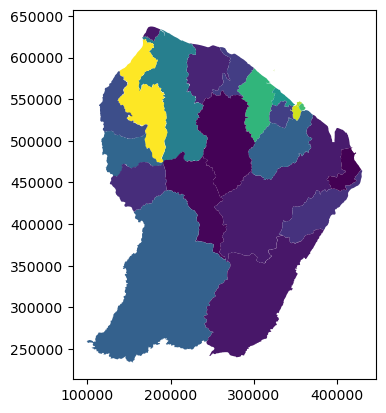

In [173]:
depcom_geometries.merge(year_dfs[0], on="depcom").plot("app")

<Axes: >

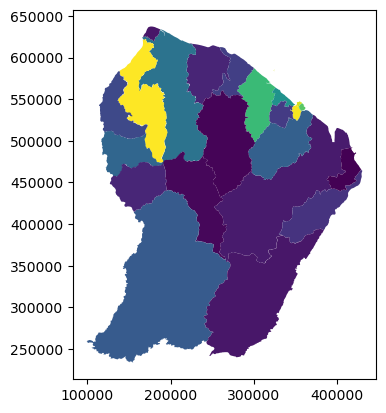

In [174]:
depcom_geometries.merge(year_dfs[0], on="depcom").plot("disapp")

2017
2018
2019
2020
2021
2022


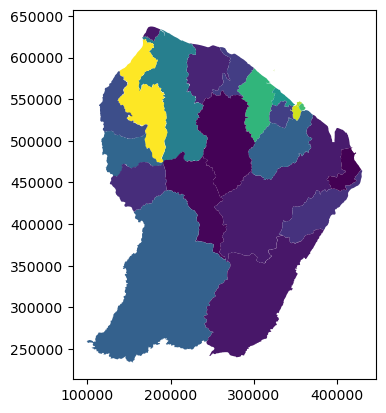

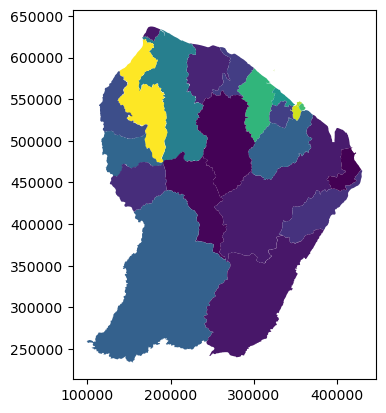

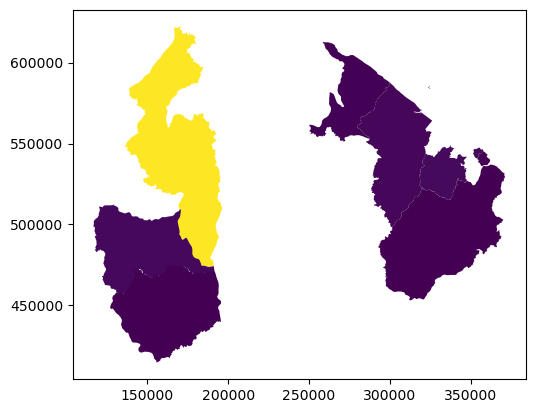

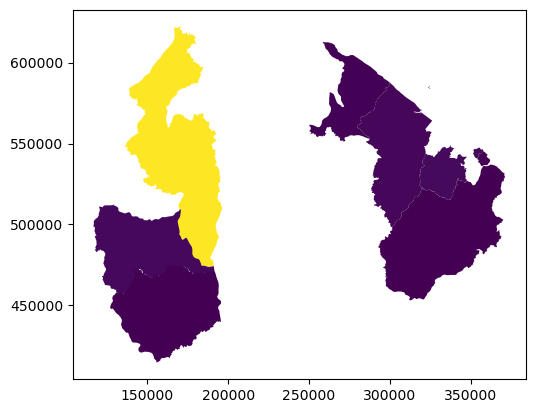

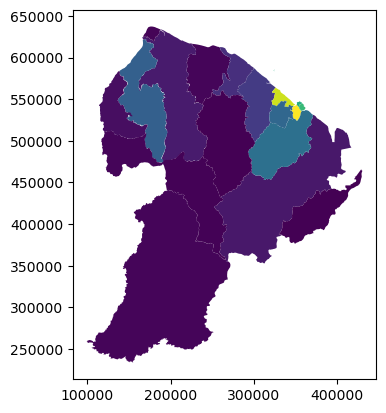

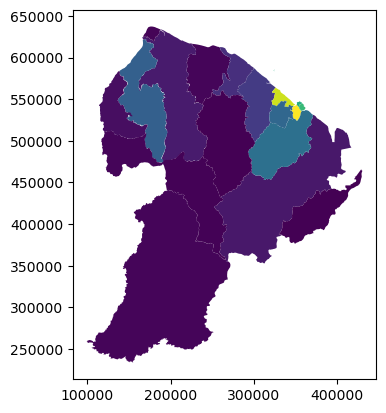

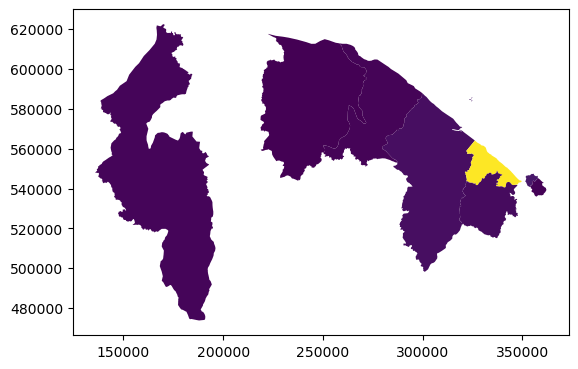

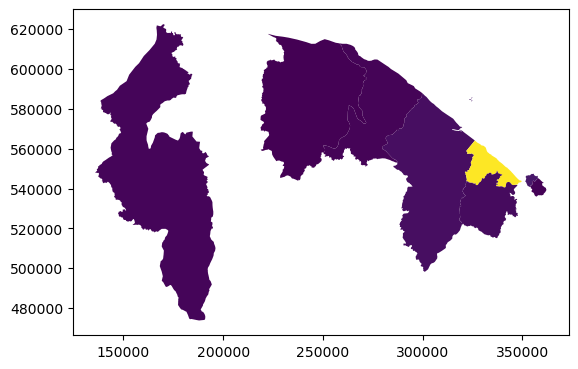

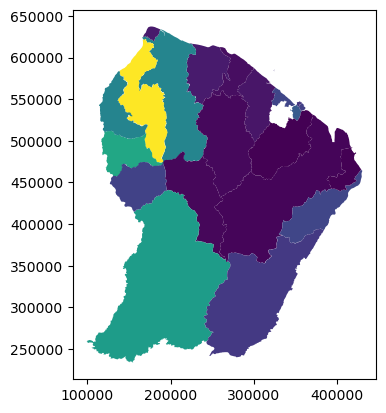

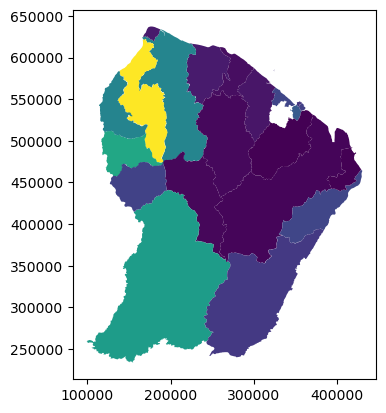

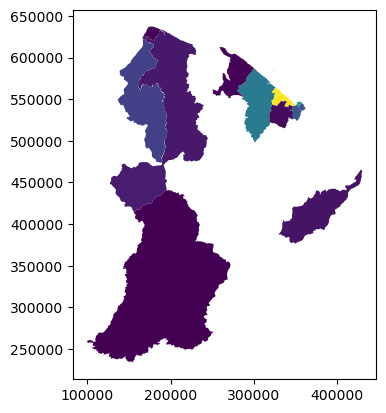

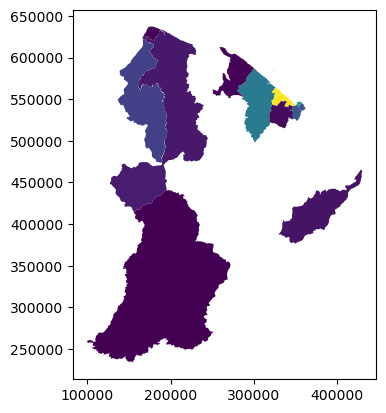

In [177]:
for i in range(len(year_dfs)):
    print(year_dfs[i].year[0])
    depcom_geometries.merge(year_dfs[i], on="depcom").plot("app")
    depcom_geometries.merge(year_dfs[i], on="depcom").plot("app")